# Data Exploration and Shift Detection in eICU Dataset 1

## 1. Environment Setup



In [141]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from pathlib import Path

sns.set(style="whitegrid")
%matplotlib inline


In [142]:
# Define paths
base_path = Path("eicu-collaborative-research-database-2.0")
diag_path = base_path / "diagnosis.csv.gz"
patient_path = base_path / "patient.csv.gz"
apache_path = base_path / "apachePatientResult.csv.gz"

## 2. Load Diagnosis Data



In [143]:
# Load diagnosis data
df_diag = pd.read_csv(diag_path, compression="gzip")
print("Diagnosis columns:", df_diag.columns.tolist())
df_diag.head()



Diagnosis columns: ['diagnosisid', 'patientunitstayid', 'activeupondischarge', 'diagnosisoffset', 'diagnosisstring', 'icd9code', 'diagnosispriority']


,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,4222318,141168,False,72,cardiovascular|chest pain / ASHD|coronary arte...,"414.00, I25.10",Other
1,3370568,141168,True,118,cardiovascular|ventricular disorders|cardiomyo...,NaN,Other
2,4160941,141168,False,72,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
3,4103261,141168,True,118,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
4,3545241,141168,True,118,cardiovascular|ventricular disorders|congestiv...,"428.0, I50.9",Other


In [144]:
# Load patient data
df_pat = pd.read_csv(patient_path, compression="gzip")
print("Patient columns:", df_pat.columns.tolist())
df_pat.head()


Patient columns: ['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age', 'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx', 'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset', 'hospitaladmitsource', 'hospitaldischargeyear', 'hospitaldischargetime24', 'hospitaldischargeoffset', 'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype', 'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype', 'admissionweight', 'dischargeweight', 'unitdischargetime24', 'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus', 'uniquepid']


,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,...,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851
1,141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870
2,141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,...,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276
4,141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,...,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665


In [145]:
# Load apache results (includes mortality)
df_apache = pd.read_csv(apache_path, compression="gzip")
print("Apache columns:\n", df_apache.columns.tolist())

# Check mortality values
print("\nMortality value counts:")
print(df_apache["actualhospitalmortality"].value_counts(dropna=False))


Apache columns:
 ['apachepatientresultsid', 'patientunitstayid', 'physicianspeciality', 'physicianinterventioncategory', 'acutephysiologyscore', 'apachescore', 'apacheversion', 'predictedicumortality', 'actualicumortality', 'predictediculos', 'actualiculos', 'predictedhospitalmortality', 'actualhospitalmortality', 'predictedhospitallos', 'actualhospitallos', 'preopmi', 'preopcardiaccath', 'ptcawithin24h', 'unabridgedunitlos', 'unabridgedhosplos', 'actualventdays', 'predventdays', 'unabridgedactualventdays']

Mortality value counts:
actualhospitalmortality
ALIVE      269590
EXPIRED     27474
Name: count, dtype: int64


## 3. Merge Hospital or Unit Metadata




In [146]:
# Merge: patient + apache (on patientunitstayid)
# df = df_pat.merge(df_apache[["patientunitstayid", "actualhospitalmortality"]], on="patientunitstayid", how="left")

# # Merge: + diagnosis (optional, we can use priority etc)
# df = df.merge(df_diag[["patientunitstayid", "diagnosispriority"]], on="patientunitstayid", how="left")

# print("Final merged columns:", df.columns.tolist())
# df.head()




In [ ]:
# Safely merge all necessary info upfront
# After merging:
# Merge everything upfront (keep only patientunitstayid, mortality, diagnosispriority)
df = df_pat.merge(
    df_apache[["patientunitstayid", "actualhospitalmortality"]],
    on="patientunitstayid",
    how="left"
)
print("After apache merge:", df.shape)
print(df["actualhospitalmortality"].value_counts(dropna=False))

df = df.merge(
    df_diag[["patientunitstayid", "diagnosispriority"]],
    on="patientunitstayid",
    how="left"
)
print("After diagnosis merge:", df.shape)
print(df["diagnosispriority"].value_counts(dropna=False))

# Drop rows where actualhospitalmortality is missing
df = df.dropna(subset=["actualhospitalmortality"])

# Rename the column and convert to binary
df.rename(columns={"actualhospitalmortality": "mortality"}, inplace=True)
df["mortality"] = df["mortality"].map({"ALIVE": 0, "EXPIRED": 1})

# Drop rows where mapping failed (i.e. still NaN after map)
df = df.dropna(subset=["mortality"])

# Encode diagnosispriority
df = df.dropna(subset=["diagnosispriority"])  # make sure we're not encoding NaNs
df["diagnosispriority_encoded"] = pd.factorize(df["diagnosispriority"])[0]

# Preview
print(df[["diagnosispriority", "diagnosispriority_encoded", "mortality"]].head())
print("Unique diagnosispriority values:", df["diagnosispriority"].unique())
print("Value counts:")
print(df["diagnosispriority"].value_counts())
print("Final df shape:", df.shape)
print("Final df columns:", df.columns.tolist())




After apache merge: (349391, 30)
actualhospitalmortality
ALIVE      269590
NaN         52327
EXPIRED     27474
Name: count, dtype: int64
After diagnosis merge: (5048437, 31)
diagnosispriority
Other      2131994
Major      2055491
Primary     827218
NaN          33734
Name: count, dtype: int64
  diagnosispriority  diagnosispriority_encoded  mortality
0             Other                          0          1
1             Other                          0          1
2             Other                          0          1
3             Other                          0          1
4             Other                          0          1
Unique diagnosispriority values: ['Other' 'Primary' 'Major']
Value counts:
diagnosispriority
Other      1982296
Major      1871546
Primary     754220
Name: count, dtype: int64
Final df shape: (4608062, 32)
Final df columns: ['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age', 'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx', 'admissi

In [148]:
# # Rename column
# df.rename(columns={"actualhospitalmortality": "mortality"}, inplace=True)

# # Convert string labels to binary (0/1)
# df["mortality"] = df["mortality"].map({"ALIVE": 0, "EXPIRED": 1})

# # Drop any rows where mortality couldn't be mapped (just in case)
# df = df.dropna(subset=["mortality"])

# # Encode diagnosispriority
# df["diagnosispriority_encoded"] = pd.factorize(df["diagnosispriority"])[0]

# # Preview result
# df[["diagnosispriority", "diagnosispriority_encoded", "mortality"]].head()

# print("Final df columns:", df.columns.tolist())


## 4. Define Shift Dimension




In [149]:
# Define the shift dimension
# Shift dimension
SHIFT_TYPE = "inter-hospital"  # or "inter-unit"
shift_col = "hospitalid" if SHIFT_TYPE == "inter-hospital" else "unittype"



## 5. Select Feature to Evaluate Shift



In [150]:
# Encode categorical feature for testing
# df = df.dropna(subset=["diagnosispriority"])
# df["diagnosispriority_encoded"] = pd.factorize(df["diagnosispriority"])[0]
# feature = "diagnosispriority_encoded"

# balanced_hospitals = []

# for hosp in df[shift_col].unique():
#     subset = df[df[shift_col] == hosp]
#     if subset['mortality'].nunique() >= 2:
#         balanced_hospitals.append(hosp)

# print(f"Found {len(balanced_hospitals)} hospitals with both 0 and 1 mortality")

print("mortality column unique values:", df["mortality"].unique())
print("Number of NaNs in mortality:", df["mortality"].isna().sum())
print("Length of df:", len(df))


print("df columns at this point:", df.columns.tolist())


mortality column unique values: [1 0]
Number of NaNs in mortality: 0
Length of df: 4608062
df columns at this point: ['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age', 'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx', 'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset', 'hospitaladmitsource', 'hospitaldischargeyear', 'hospitaldischargetime24', 'hospitaldischargeoffset', 'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype', 'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype', 'admissionweight', 'dischargeweight', 'unitdischargetime24', 'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus', 'uniquepid', 'mortality', 'diagnosispriority', 'diagnosispriority_encoded']


In [151]:
# Group mortality by hospital
mortality_counts = df.groupby("hospitalid")["mortality"].value_counts().unstack().fillna(0)
mortality_counts.columns = ["ALIVE", "EXPIRED"] if 0 in mortality_counts.columns else mortality_counts.columns
mortality_counts["total"] = mortality_counts.sum(axis=1)

print(mortality_counts.sort_values("total", ascending=False).head(10))


               ALIVE   EXPIRED      total
hospitalid                               
420         978608.0  221292.0  1199900.0
188         189070.0   28990.0   218060.0
122         138004.0   35032.0   173036.0
142          84820.0   32822.0   117642.0
227          71910.0   22008.0    93918.0
226          68412.0   18140.0    86552.0
79           63792.0   16822.0    80614.0
73           63062.0   14744.0    77806.0
110          62570.0   14656.0    77226.0
243          61276.0   15440.0    76716.0


## 6. Visualize Feature Distribution by Group


/var/folders/5y/v983zg9s5mj989l04vv_c3lc0000gn/T/ipykernel_31056/1702833797.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="hospitalid")


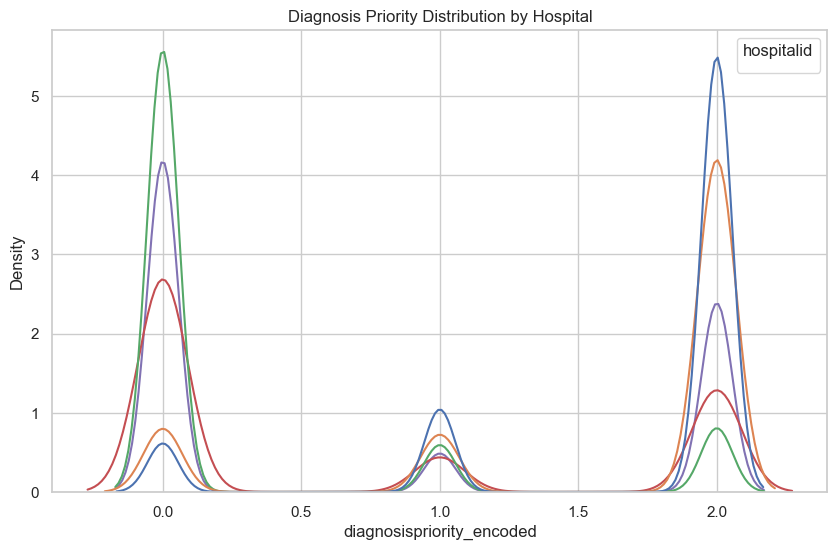

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use only the top 5 hospitals by patient count
top_hospitals = df["hospitalid"].value_counts().nlargest(5).index.tolist()
subset_df = df[df["hospitalid"].isin(top_hospitals)]

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=subset_df,
    x="diagnosispriority_encoded",
    hue=subset_df["hospitalid"].astype(str),
    common_norm=False,
    warn_singular=False
)
plt.title("Diagnosis Priority Distribution by Hospital")
plt.xlabel("diagnosispriority_encoded")
plt.ylabel("Density")
plt.legend(title="hospitalid")
plt.show()




## 7. Perform KS Test Between Two Groups

A low p-value (e.g., < 0.05) indicates significant distribution shift.


In [ ]:
from scipy.stats import ks_2samp

# Get two most frequent hospitals
top_two = df["hospitalid"].value_counts().nlargest(2).index.tolist()

# Extract encoded diagnosis values
group1 = df[df["hospitalid"] == top_two[0]]["diagnosispriority_encoded"].dropna()
group2 = df[df["hospitalid"] == top_two[1]]["diagnosispriority_encoded"].dropna()

# Run KS test
stat, p_value = ks_2samp(group1, group2)
print(f"KS test between hospital {top_two[0]} and {top_two[1]}:")
print(f"  KS Statistic: {stat:.4f}")
print(f"  P-value: {p_value:.4f}")


KS test between hospital 420 and 188:
  KS Statistic: 0.2228
  P-value: 0.0000


## 8. Save Train/Test Cohort Splits



In [ ]:

from pathlib import Path

# Define the train/test cohorts based on top 2 hospitals
train_df = df[df["hospitalid"] == top_two[0]].copy()
test_df = df[df["hospitalid"] == top_two[1]].copy()

# Confirm shape and saving full cohorts
print(f"Train cohort shape: {train_df.shape}")
print(f"Test cohort shape: {test_df.shape}")

Path("cohorts").mkdir(exist_ok=True)
train_df.to_csv("cohorts/train.csv", index=False)
test_df.to_csv("cohorts/test.csv", index=False)

# Sampling 500
if len(train_df) >= 500 and len(test_df) >= 500:
    sample_train = train_df.sample(n=500, random_state=42)
    sample_test = test_df.sample(n=500, random_state=42)
else:
    sample_train = train_df
    sample_test = test_df
    print("Not enough data to sample 500. Using full sets.")

# Save sample cohorts
sample_train.to_csv("cohorts/train_inter_sample.csv", index=False)
sample_test.to_csv("cohorts/test_inter_sample.csv", index=False)


Train cohort shape: (1199900, 32)
Test cohort shape: (218060, 32)


making sample of 500

In [161]:
# Re-load the sample cohorts
df_apache = pd.read_csv(apache_path, compression="gzip")[["patientunitstayid", "actualhospitalmortality"]]

df_train = pd.read_csv("cohorts/train.csv").merge(df_apache, on="patientunitstayid", how="left")
df_test = pd.read_csv("cohorts/test.csv").merge(df_apache, on="patientunitstayid", how="left")



/var/folders/5y/v983zg9s5mj989l04vv_c3lc0000gn/T/ipykernel_31056/2231831008.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("cohorts/train.csv").merge(df_apache, on="patientunitstayid", how="left")


logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select features and labels
X_train = df_train[["diagnosispriority_encoded"]]
y_train = df_train["mortality"]

X_test = df_test[["diagnosispriority_encoded"]]
y_test = df_test["mortality"]

# Scale features (not strictly needed with one column, but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)

# Evaluate model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[378140      0]
 [ 57980      0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    378140
           1       0.00      0.00      0.00     57980

    accuracy                           0.87    436120
   macro avg       0.43      0.50      0.46    436120
weighted avg       0.75      0.87      0.81    436120



/Users/annabelsimpson/anaconda3/envs/eicu-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/annabelsimpson/anaconda3/envs/eicu-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/annabelsimpson/anaconda3/envs/eicu-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p